# GAN

GANでMNISTを生成する。  
DeepConvolutionalじゃないGAN。なるべくシンプルな実装を目指す。

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import display

batch_size = 64 # バッチサイズ
nz = 100 # 潜在変数の次元数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## MNIST

In [2]:
dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True # バッチサイズがずれると面倒くさいので最後は切り捨て
)

sample_X, _ = next(iter(dataloader))
w, h = sample_X.shape[2:]
image_size = w * h
print("batch shape:", sample_X.shape)
print("width:", w)
print("height:", h)
print("image size:", image_size)

batch shape: torch.Size([64, 1, 28, 28])
width: 28
height: 28
image size: 784


## Discriminator

全結合とReLUで構築

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(), # 1x28x28 -> 784
            nn.Linear(image_size, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU()
            nn.Linear(128, 1),
            nn.Sigmoid(), # 確率なので0~1に
        )

    def forward(self, x):
        y = self.net(x)
        return y

## Generator

全結合とReLUとバッチ正規化で構築

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self._linear(nz, 128),
            self._linear(128, 256),
            self._linear(256, 512),
            nn.Linear(512, image_size),
            nn.Sigmoid() # 濃淡を0~1に
        )

    def _linear(self, input_size, output_size):
        return nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.BatchNorm1d(output_size),
            nn.ReLU()
        )

    def forward(self, x):
        y = self.net(x)
        y = y.view(-1, 1, w, h) # 784 -> 1x28x28
        return y

## 学習

In [5]:
# ノイズを生成
def make_noise(batch_size):
    return torch.randn(batch_size, nz, device=device)

# 画像描画
def write(netG, n_rows=1, n_cols=8, size=64):
    z = make_noise(n_rows*n_cols)
    images = netG(z)
    images = transforms.Resize(size)(images)
    img = torchvision.utils.make_grid(images, n_cols)
    img = transforms.functional.to_pil_image(img)
    display(img)

今回は本物を0, 偽物を1とする。  
Generatorが生成した偽物をDiscriminatorで判定したときに0になるように学習する。

**0に近づきたい = 小さくしたい** と捉えられるので、Discriminatorの出力をそのまま**損失**として扱って逆伝播を行う

ただ一般的には、Discriminatorの出力を交差エントロピーに入れたものを損失として扱う。その方が損失が指数関数になるので学習が上手く進む（多分）。  
交差エントロピーを使うときは、0, 1の値はどっちでもいい。本物を1, 偽物を0とすることが多い気がする。

In [6]:
real_labels = torch.zeros(batch_size, 1).to(device) # 正解のラベル
fake_labels = torch.ones(batch_size, 1).to(device) # 偽物のラベル
criterion = nn.BCELoss()


def train(netD, netG, optimD, optimG, n_epochs, write_interval=1):
    # 学習モード
    netD.train()
    netG.train()

    for epoch in range(1, n_epochs+1):
        for x, _ in dataloader:
            x = x.to(device)

            # 勾配をリセット
            optimD.zero_grad()
            optimG.zero_grad()

            # Discriminatorの学習
            z = make_noise(batch_size) # ノイズを生成
            fake = netG(z) # 偽物を生成
            pred_fake = netD(fake) # 偽物を判定
            pred_real = netD(x) # 本物を判定
            loss_fake = criterion(pred_fake, fake_labels) # 偽物の誤差
            loss_real = criterion(pred_real, real_labels) # 本物の誤差
            lossD = loss_fake + loss_real # 誤差の合計
            lossD.backward() # 逆伝播
            optimD.step() # パラメータ更新

            # Generatorの学習
            fake = netG(z) # 偽物を生成
            pred = netD(fake) # 偽物を判定
            lossG = pred.sum() # 和をとる
            lossG.backward() # 逆伝播
            optimG.step() # パラメータ更新

        print(f'{epoch:>3}epoch | lossD: {lossD:.4f}, lossG: {lossG:.4f}')
        if epoch % write_interval == 0:
            write(netG)

  1epoch | lossD: 0.0168, lossG: 63.8954


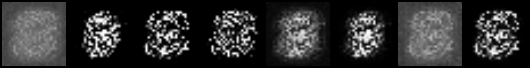

  2epoch | lossD: 0.0002, lossG: 63.9862


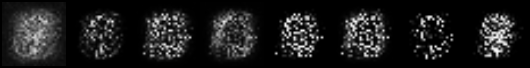

  3epoch | lossD: 0.0037, lossG: 63.8015


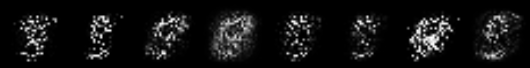

  4epoch | lossD: 0.0025, lossG: 63.9371


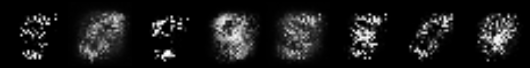

  5epoch | lossD: 0.0185, lossG: 63.4929


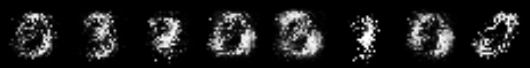

In [7]:
netD = Discriminator().to(device)
netG = Generator().to(device)
optimD = optim.Adam(netD.parameters(), lr=0.0002)
optimG = optim.Adam(netG.parameters(), lr=0.0002)
n_epochs = 5

train(netD, netG, optimD, optimG, n_epochs)

いい感じに成長していそうなので、このまま30回学習させる

  1epoch | lossD: 0.0445, lossG: 63.7471
  2epoch | lossD: 0.1797, lossG: 61.7425
  3epoch | lossD: 0.1017, lossG: 62.3329
  4epoch | lossD: 0.1938, lossG: 61.1345
  5epoch | lossD: 0.2365, lossG: 58.6654


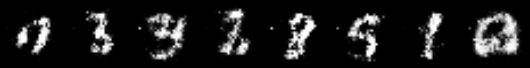

  6epoch | lossD: 0.3200, lossG: 60.8532
  7epoch | lossD: 0.2655, lossG: 58.0938
  8epoch | lossD: 0.5659, lossG: 54.9554
  9epoch | lossD: 0.5412, lossG: 51.4962
 10epoch | lossD: 0.7515, lossG: 55.6216


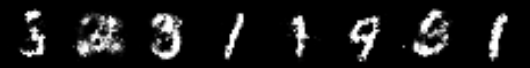

 11epoch | lossD: 0.8816, lossG: 49.2700
 12epoch | lossD: 0.7401, lossG: 51.2573
 13epoch | lossD: 0.8532, lossG: 49.3360
 14epoch | lossD: 0.8391, lossG: 48.2373
 15epoch | lossD: 0.7813, lossG: 46.8363


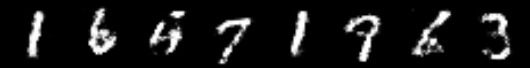

 16epoch | lossD: 0.8701, lossG: 46.3742
 17epoch | lossD: 0.9697, lossG: 46.6109
 18epoch | lossD: 0.8219, lossG: 47.8904
 19epoch | lossD: 0.7972, lossG: 47.1275
 20epoch | lossD: 0.7794, lossG: 46.6853


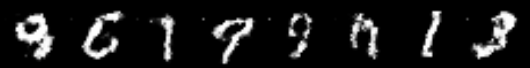

 21epoch | lossD: 0.8247, lossG: 46.6405
 22epoch | lossD: 1.0000, lossG: 45.3410
 23epoch | lossD: 0.9049, lossG: 48.2510
 24epoch | lossD: 0.8211, lossG: 44.8736
 25epoch | lossD: 0.9928, lossG: 45.9630


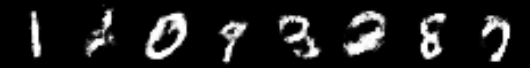

 26epoch | lossD: 0.9469, lossG: 45.5254
 27epoch | lossD: 0.7711, lossG: 47.8420
 28epoch | lossD: 0.8560, lossG: 45.7546
 29epoch | lossD: 0.8795, lossG: 43.5564
 30epoch | lossD: 0.8293, lossG: 47.1261


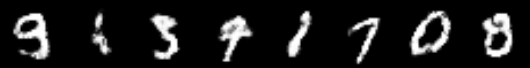

In [8]:
train(netD, netG, optimD, optimG, 30, write_interval=5)

学習完了。結果はこうなった↑。

もう少し見てみる

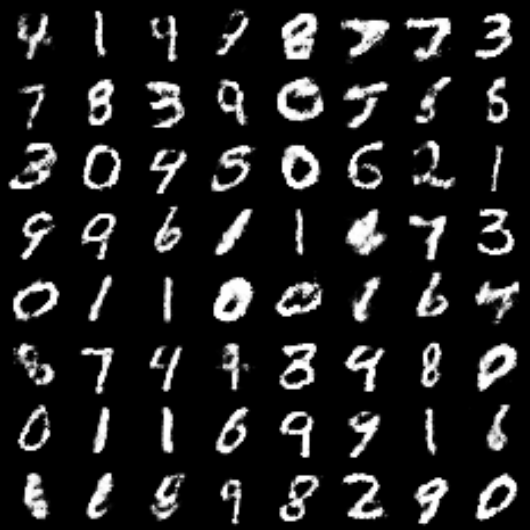

In [9]:
write(netG, 8)

上手く学習できた